In [1]:
import pandas as pd
import DataLoading
import torch
import matplotlib.pyplot as plt
import NN_evaluation
import numpy as np 
import seaborn as sns

In [2]:
sc = "sc01"
period = "2030"
case= "IEEE118"
folder = f"../Data/{case}_DC_fy/"
nb_IC_runs_map = {"3-bus":20,"9n":74,"RTS24":80,"RTS24_mod1": 18}


In [3]:
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.3
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"],"SystemCosts")
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter,all_executions)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

t_in_fy, t_out_fy, t_inter_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in=dfs_in, dfs_out=dfs_out, dfs_inter_j=dfs_inter_j,executions=all_executions,normalize_out=True)


input_f_sc01_Network_Existing_Generation_Full_2030.csv
155
input_f_sc01_Network_Full_Generation_Full_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus008_bus030_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus012_bus117_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus015_bus033_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus023_bus024_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus023_bus032_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus025_bus027_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus030_bus038_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus033_bus037_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus065_bus068_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus068_bus069_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus074_bus075_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus077_bus082_cac1_2030.csv
155
input_f_sc01_PINT_Network_Line_In_bus080_bus099_cac1_2030.csv
155
input_f_sc01_PINT_Network_Li

In [4]:
#Calculate some overall metrics such as variance 
torch.mean(t_in_fy,axis = 0)
print("Input standard dev:", torch.std(t_in_fy,axis = 0))

torch.mean(t_inter_fy,axis = 0)
print("Intermediate layer standard dev:",torch.std(t_inter_fy,axis = 0))

print("Output standard dev:",torch.std(t_out_fy,axis = 0))
torch.mean(t_out_fy,axis = 0)


Input standard dev: tensor([0.2780, 0.1869, 0.1869, 0.0437, 0.2946, 0.2946, 0.2946, 0.4685, 0.4685,
        0.0518, 0.0518, 0.0518, 0.4630, 0.4630, 0.0000, 0.2893, 0.2706, 0.4718,
        0.4718, 0.2922, 0.1009, 0.1009, 0.1009, 0.1009, 0.0000, 0.1009, 0.1009,
        0.0000, 0.0000, 0.0000, 0.1009, 0.1009, 0.1009, 0.1009, 0.1009, 0.1009,
        0.1009, 0.1009, 0.1009, 0.1009, 0.1009, 0.1009, 0.1009, 0.0000, 0.0000,
        0.0000, 0.1009, 0.1009, 0.1009, 0.0000, 0.1009, 0.1009, 0.1128, 0.1128,
        0.1128, 0.1128, 0.0000, 0.0000, 0.1128, 0.1128, 0.1128, 0.1128, 0.1128,
        0.1128, 0.1128, 0.1128, 0.1128, 0.1128, 0.1128, 0.1128, 0.1128, 0.1128,
        0.1128, 0.1128, 0.1128, 0.1128, 0.1128, 0.1128, 0.1128, 0.1128, 0.0000,
        0.1128, 0.0000, 0.0000, 0.0000, 0.1128, 0.1128, 0.0000, 0.0000, 0.1009,
        0.0000, 0.0000, 0.0000, 0.1009, 0.1009, 0.1128, 0.1128, 0.1128, 0.1128,
        0.1128, 0.0000, 0.1098, 0.1098, 0.1098, 0.1098, 0.1098, 0.0000, 0.1098,
        0.0000, 0.10

tensor(0.0330, dtype=torch.float64)

In [5]:
np_out_original_full = t_out_fy.numpy()*maxs["out_scalar"].numpy()

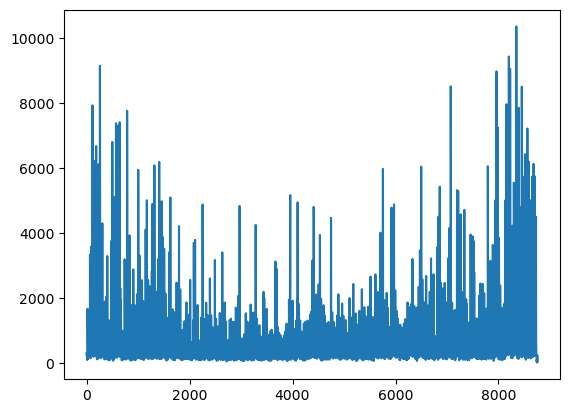

In [6]:
plt.plot(np_out_original_full[0:8760])

In [7]:
#Look at the average difference and percentual deviation incurred by installing all candidates
existing_actual = NN_evaluation.get_actual_from_dfs_out(all_executions[0],dfs_out)/maxs["out_scalar"]
full_actual = NN_evaluation.get_actual_from_dfs_out(all_executions[1],dfs_out)/maxs["out_scalar"]

differences = existing_actual - full_actual
deviation_existing = torch.div(differences,existing_actual) 

print(torch.mean(deviation_existing),torch.median(deviation_existing), torch.std(deviation_existing))
#plt.boxplot(differences.detach().numpy())
#plt.boxplot(deviation_existing.detach().numpy())

tensor(0.7454, dtype=torch.float64) tensor(0.7980, dtype=torch.float64) tensor(0.1954, dtype=torch.float64)


In [8]:
#Collect difference and deviation incurred by individual candidates in dataframe
ics = DataLoading.list_investments_candidates_from_execs(executions=all_executions)
df_lb = pd.DataFrame()
for ic in ics:
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]

    ex_actual_P = NN_evaluation.get_actual_from_dfs_out(ex_P,dfs_out)/maxs["out_scalar"]
    ex_actual_T = NN_evaluation.get_actual_from_dfs_out(ex_T,dfs_out)/maxs["out_scalar"]

    lb_P = existing_actual -ex_actual_P
    lb_T = - (full_actual - ex_actual_T)
    print(ic, "PINT: ", lb_P.sum().item(),"TOOT:",lb_T.sum().item())

    lb = (lb_P + lb_T)/2
    df_lb[ic] = lb
    #ic,ex_P,ex_T,lb.sum()
df_lb_dev = df_lb.div(existing_actual,axis=0)

bus008_bus030_cac1 PINT:  1.1351625629069106e-10 TOOT: 71.68121723913916
bus012_bus117_cac1 PINT:  -49.672207707911355 TOOT: 635.6274260223429
bus015_bus033_cac1 PINT:  151.1451916144822 TOOT: 33.81819386874795
bus023_bus024_cac1 PINT:  1.0558319199876611 TOOT: 1.2944808138422472
bus023_bus032_cac1 PINT:  22.177174359187077 TOOT: 71.19400283737185
bus025_bus027_cac1 PINT:  37.66930923448001 TOOT: 5.09231889479217
bus030_bus038_cac1 PINT:  34.41443137464775 TOOT: 41.40190465269157
bus033_bus037_cac1 PINT:  12.797905308844307 TOOT: 3.83108966671185
bus065_bus068_cac1 PINT:  4.123472772500598 TOOT: 29.197200169362127
bus068_bus069_cac1 PINT:  -4.856743648216348 TOOT: 6.774841310673229
bus074_bus075_cac1 PINT:  0.16303354829581468 TOOT: 1.2831807624108216
bus077_bus082_cac1 PINT:  -1.7053109193605136 TOOT: 1.1706875599703932
bus080_bus099_cac1 PINT:  1.250047521616159 TOOT: 1.5333320386441773
bus082_bus083_cac1 PINT:  10.345300558865905 TOOT: 21.0867339091879
bus093_bus094_cac1 PINT:  3.49

In [16]:
#Model deviations
hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_20"
hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_80"
hyperloop_name = "Decay_2016h_rand_Weeks_RTS24_DC_0.25_v0.33_PF_0_80"
#hyperloop_name = f"Decay_2016h_rand_Days_{case}_DC_0.25_v0.33_PF_0_{nb_IC_runs_map[case]}"
#hyperloop_name = f"Decay_rand_Weeks_{case}_DC_0.25_v0.33_PF_0_{nb_IC_runs_map[case]}"
hyperloop_name = f"{case}_DC_0.25_v0.33_PF"

hour_limit = 2016
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)
f = df_losses.Nb_hours_used <=hour_limit

loss_to_sort = "Te_l_mae"
xth_best = 1

row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
# if row.Sel_method.item() == "Hours": 
#     hyperloop_name = f"Decay_rand_Hours_{case}_DC_0.25_v0.33_PF_0_80"
# elif row.Sel_method.item() == "Days":
#     hyperloop_name = f"Decay_rand_Days_{case}_DC_0.25_v0.33_PF_0_80"
#     hyperloop_name = "Decay_2016h_rand_Days_RTS24_DC_0.25_v0.33_PF_0_80"
# else: 
#     print("Problem")

m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False,hidden_sizes = None,new_name = True)
prediction = m(t_in_fy.float())[0].squeeze().detach().numpy()

diff = prediction - t_out_fy.numpy().transpose()
dev = diff/prediction

[60, 60, 162, 170, 85]
OE_2016hours_3-1h_128e_0.0025-32-1lr_0dor_Falsero_128bs_0.1ill_TrueMAE all_epochs
trained_models/IEEE118_DC_0.25_v0.33_PF/all_epochs/model_OE_2016hours_3-1h_128e_0.0025-32-1lr_0dor_Falsero_128bs_0.1ill_TrueMAE.pth


In [17]:
'trained_models/IEEE118_DC_0.25_v0.33_PF/min_val/model_OE_2016hours_3-1h_256e_0.0025-64-1.0lr_1dor_Falsero_128bs_0.1ill_TrueMAE.pth'
'trained_models/IEEE118_DC_0.25_v0.33_PF/min_val/model_OE_2016hours_3-1h_256e_0.0025-64-1'

'trained_models/IEEE118_DC_0.25_v0.33_PF/min_val/model_OE_2016hours_3-1h_256e_0.0025-64-1'

In [18]:
def get_exec_indices_PT(ic,all_executions):
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]
    return ex_P,ex_T
    
def get_lb_actual_PT(ic,dfs_out,all_executions,maxs): 
    ex_P,ex_T = get_exec_indices_PT(ic,all_executions)

    ex_actual_P = (NN_evaluation.get_actual_from_dfs_out(ex_P,dfs_out) - maxs["out_shift"])/maxs["out_scalar"]
    ex_actual_T = (NN_evaluation.get_actual_from_dfs_out(ex_T,dfs_out)- maxs["out_shift"])/maxs["out_scalar"]

    lb_P = existing_actual -ex_actual_P
    lb_T = - (full_actual - ex_actual_T)

    lb = (lb_P + lb_T)/2
    return lb
def get_lb_estimated_PT(m,ic,dfs_in,all_executions,maxs):
    ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
    ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
    ex_P  = all_executions[ix_P[0]]
    ex_T = all_executions[ix_T[0]]


    est_ic_P = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_P,dfs_in,maxs)
    est_ic_T = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_T,dfs_in,maxs)

    est_exis = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[0],dfs_in,maxs)
    est_full = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[1],dfs_in,maxs)

    lb_P =  est_exis-est_ic_P
    lb_T = - (est_full - est_ic_T)
    lb = (lb_P + lb_T)/2
    return lb

In [19]:
ix_P = [i for i, string in enumerate(all_executions) if ic in string and "PINT" in string]
ix_T = [i for i, string in enumerate(all_executions) if ic in string and "TOOT" in string]
ex_P  = all_executions[ix_P[0]]
ex_T = all_executions[ix_T[0]]


est_ic_P = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_P,dfs_in,maxs)
est_ic_T = NN_evaluation.get_NN_estimates_from_dfs_in(m,ex_T,dfs_in,maxs)

est_exis = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[0],dfs_in,maxs)
est_full = NN_evaluation.get_NN_estimates_from_dfs_in(m,all_executions[1],dfs_in,maxs)

lb_P =  est_exis-est_ic_P
lb_T = - (est_full - est_ic_T)
lb = (lb_P + lb_T)/2
lb.sum()

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


6.9326887

In [20]:
est_exis.sum()

403.9861

In [21]:
#Collect both actual and estimated line benefits incurred by individual candidates in dataframe
ics = DataLoading.list_investments_candidates_from_execs(executions=all_executions)
df_lb = pd.DataFrame()
sums_lb = pd.DataFrame()
i=0
for ic in ics:
    lb_actual = get_lb_actual_PT(ic = ic,dfs_out=dfs_out,all_executions=all_executions,maxs = maxs)
    lb_est = get_lb_estimated_PT(m=m,ic=ic,dfs_in=dfs_in,all_executions=all_executions,maxs=maxs)

    df_lb[f"{ic}_actual"] = lb_actual
    df_lb[f"{ic}_estimate"] = lb_est
    correl = np.corrcoef(lb_actual,lb_est)[0,1]
    row_act = pd.DataFrame({"LB sum": lb_actual.sum().item(),"AE":"Actual","IC":ic,"Correl": correl },index = [i])
    i+=1
    row_est = pd.DataFrame({"LB sum": lb_est.sum(),"AE":"Estimate","IC":ic,"Correl": correl},index = [i])
    i+=1
    sums_lb = pd.concat([sums_lb,row_act,row_est])
sums_lb_frac = sums_lb
#sums_lb_frac["LB sum"] = sums_lb_frac["LB sum"]/existing_actual.sum().item()

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\_tensor.py:852: RuntimeWarning: invalid value encountered in multiply
  return self.recipro

In [22]:
existing_actual.sum(), full_actual.sum()

(tensor(445.5261, dtype=torch.float64), tensor(90.7412, dtype=torch.float64))

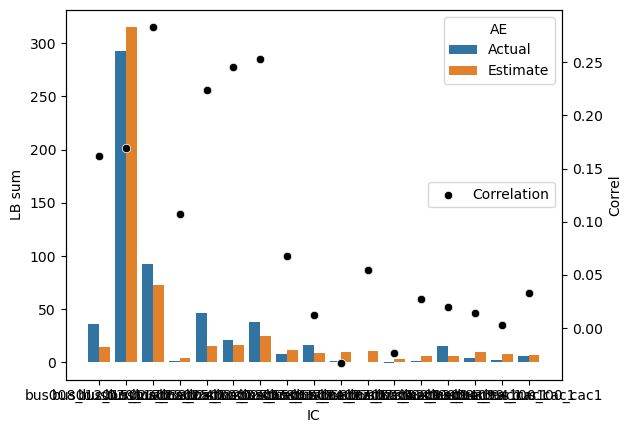

In [23]:
fig, ax = plt.subplots()
sns.barplot(data = sums_lb,x = "IC",y = "LB sum",hue = "AE")

ax2 = ax.twinx()
sns.scatterplot(x='IC', y='Correl', data=sums_lb, color='black', markers=True, ax=ax2,label = "Correlation")
ax2.legend(loc="right")
#plt.savefig(f"Figures/LineBenefits/Summed_Benefits_and_correl_{case}_{hour_limit}")

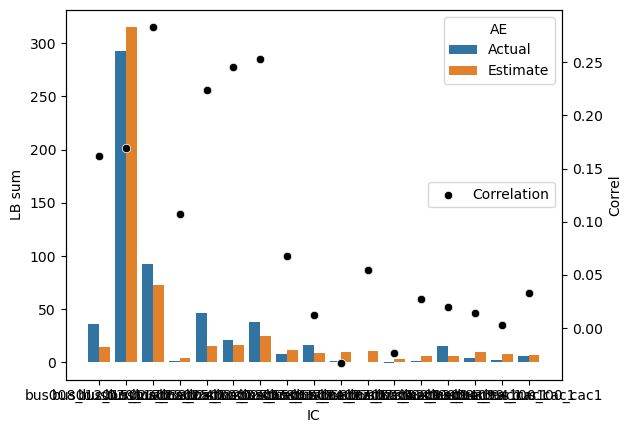

In [24]:
fig, ax = plt.subplots()
sns.barplot(data = sums_lb_frac,x = "IC",y = "LB sum",hue = "AE")

ax2 = ax.twinx()
sns.scatterplot(x='IC', y='Correl', data=sums_lb_frac, color='black', markers=True, ax=ax2,label = "Correlation")
ax2.legend(loc="right")
#plt.savefig(f"Figures/LineBenefits/Summed_Benefits_and_correl_{case}_{hour_limit}")

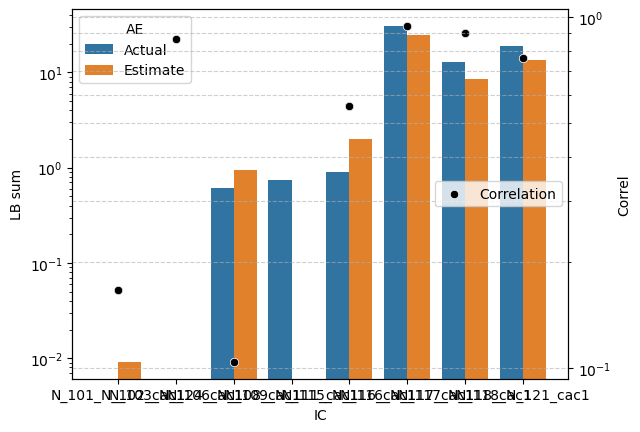

In [19]:
fig, ax = plt.subplots()

# Create the bar plot with a logarithmic y-axis
sns.barplot(data=sums_lb, x="IC", y="LB sum", hue="AE", ax=ax)
ax.set_yscale('log')  # Set the y-axis to a logarithmic scale

ax2 = ax.twinx()

# Create the scatter plot with a logarithmic y-axis
sns.scatterplot(x='IC', y='Correl', data=sums_lb, color='black', markers=True, ax=ax2,label = "Correlation")
ax2.set_yscale('log')  # Set the y-axis of the second plot to a logarithmic scale
ax2.grid(True, axis='y', linestyle='--', alpha=0.6,which = "both")  # Add grid lines to the y-axis of the second plot
plt.savefig(f"Figures/LineBenefits/Summed_Benefits_and_correl_{case}_{hour_limit}_log")
ax2.legend(loc="right")
plt.show()

N_101_N_102_cac1_actual     -0.006305
N_101_N_102_cac1_estimate    0.231927
N_101_N_103_cac1_actual     -0.311418
N_101_N_103_cac1_estimate   -0.069379
N_101_N_105_cac1_actual     -0.030752
                               ...   
N_120_N_123_cac1_estimate    0.407142
N_120_N_123_cac2_actual     -0.008833
N_120_N_123_cac2_estimate    0.167606
N_121_N_122_cac1_actual     -2.725661
N_121_N_122_cac1_estimate   -2.147458
Length: 78, dtype: float64


0.14257933027582645

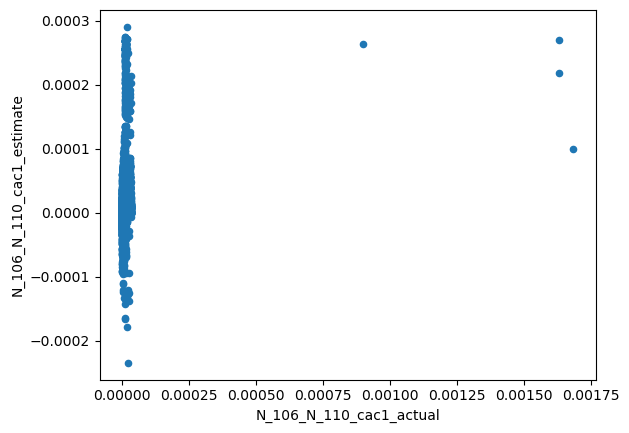

In [18]:
candidate = ics[10]
df_lb.plot.scatter(x=f"{candidate}_actual",y=f"{candidate}_estimate")
ics_only = df_losses[f][["Te_l_mse","fy_l_mse"]]
correl = df_lb.corr().loc[f"{candidate}_actual",f"{candidate}_estimate"]
correl